In [33]:
"""
Created on 25/02/22

Paramater sweep for Lyapunov algorithm on atomic coherence system
(Sweep of Lambda and omega)

Author: Patrick Munnelly

"""

import numpy as np
from numpy import sin,cos
from scipy.integrate import solve_ivp
import seaborn as sns

##############################################################################
# Define initial condition and paramater sweep range values:
    
X0 = [0.5, 0.5, 0.5, 0.5, 1]

s_omega = np.arange(1.5,5,0.1)
s_Lambda = np.arange(1.5,5,0.1)

omega = 0
Lambda = 0

##############################################################################
# Define Lorenz system:

def quantum_model(t, x):  
        
    return [
        -omega*Lambda* (x[0]*x[2])**0.5 *cos(x[3])*(sin(x[1])),  # d(I_e)/dt
        omega -0.5*omega*Lambda* (x[2]/x[0])**0.5 *(cos(x[3])*cos(x[1])),  # d(phi_e)/dt
        2*omega*x[4]*Lambda* (x[0]*x[2])**0.5 *(cos(x[1])*sin(x[3])),  # d(I_m)/dt
        omega*x[4]*Lambda* (x[0]/x[2])**0.5 *(cos(x[3])*cos(x[1])),  # d(phi_m)/dt
        -Lambda* (x[0]*x[2])**0.5 *(cos(x[1])*sin(x[3]))  # d(n)/dt
    ]

##############################################################################
# Define 2D array to hold maximum Lyapunov exponants:

MLE = np.zeros((s_omega.size, s_Lambda.size)) 

##############################################################################
# Set Lyapunov algorithm paramaters:
epsilon = 0.01  # Pertibation Amplitude
T = 2  # Integral time interval
M = 100 # Integral iterations
N = 5 # Number of state variables in our system
dt = 0.01 # Set timestep for integration

##############################################################################

for i_omega in range(s_omega.size):
    omega = s_omega[i_omega]
    Lambda = 0 # Reset Lambda for sweep with new omega value
    for i_Lambda in range(s_Lambda.size):
        Lambda = s_Lambda[i_Lambda]
    
        # Now run our Lyapunov algorithm:

        # Reference vector:
        x = X0

        # Perturbed vector:
        x_tilda = np.zeros((N,N))

        # Perturned vector relative to reference vector
        x_tilda_r = np.zeros((N,N))

        # Create initial Orthonormalised perturbed vector:
        p = ([[epsilon, 0, 0, 0, 0],
              [0, epsilon, 0, 0, 0],
              [0, 0, epsilon, 0, 0],
              [0, 0, 0, epsilon, 0],
              [0, 0, 0, 0, epsilon]])

        x_tilda_0 = [np.add(x,p[0]),
                     np.add(x,p[1]),
                     np.add(x,p[2]),
                     np.add(x,p[3]),
                     np.add(x,p[4])]

        x_tilda_0_r = np.zeros((N,N))

        S = np.zeros(N)

        ##############################################################################
        # Begin main loop:
        try:    
            for i in range(M):
                # Integrate reference vector over time T:
                sol = solve_ivp(quantum_model, (i*T, (i+1)*T), x, method='BDF', t_eval=np.arange(i*T,(i+1)*T,dt))
                x = (np.transpose(sol.y))[-1]     
                
                for j in range(N):
                    # Integrate each perturbation vector over time T:
                    # x_tilda(j) = final value of integral from (x_tilda_0(j)) over T
                    sol = solve_ivp(quantum_model, (i*T, (i+1)*T), x_tilda_0[j], method='BDF', t_eval=np.arange(i*T,(i+1)*T,dt))
                    x_tilda[j] = (np.transpose(sol.y))[-1]
                    
                    # Find the relative vector between each perturbation vector and the refernce vector:
                    x_tilda_r[j] = x_tilda[j] - x
                        
                # Complete a gram schmidt orthogonalization process on relative perturbed vectors:  
                for j in range(N):
                    for k in range(j):
                        x_tilda_r[j] = x_tilda_r[j] - (np.dot(x_tilda_r[k], x_tilda_r[j])/np.dot(x_tilda_r[k], x_tilda_r[k])) * x_tilda_r[k]
                        
                    # Update the accumulated sums with the new relative vector:
                    S[j] = S[j] + np.log(np.linalg.norm(x_tilda_r[j]/epsilon))
                    
                    x_tilda_0_r[j] = x_tilda_r[j] * epsilon / np.linalg.norm(x_tilda_r[j])
                    
                    # Compute the absolute vectors for the next iteration:
                    x_tilda_0[j] = x + x_tilda_0_r[j]
                    
            ##############################################################################
            # Calculate final Lyapunov exponant values:
     
            L_exp = S/(M*T)
            
            MLE[i_omega,i_Lambda] = np.max(L_exp)
            
        except:
            MLE[i_omega,i_Lambda] = 0


C:\Users\pmunn\AppData\Local\Temp/ipykernel_21844/3871766561.py:33: RuntimeWarning: invalid value encountered in double_scalars
  -omega*Lambda* (x[0]*x[2])**0.5 *cos(x[3])*(sin(x[1])),  # d(I_e)/dt
C:\Users\pmunn\AppData\Local\Temp/ipykernel_21844/3871766561.py:34: RuntimeWarning: invalid value encountered in double_scalars
  omega -0.5*omega*Lambda* (x[2]/x[0])**0.5 *(cos(x[3])*cos(x[1])),  # d(phi_e)/dt
C:\Users\pmunn\AppData\Local\Temp/ipykernel_21844/3871766561.py:35: RuntimeWarning: invalid value encountered in double_scalars
  2*omega*x[4]*Lambda* (x[0]*x[2])**0.5 *(cos(x[1])*sin(x[3])),  # d(I_m)/dt
C:\Users\pmunn\AppData\Local\Temp/ipykernel_21844/3871766561.py:36: RuntimeWarning: invalid value encountered in double_scalars
  omega*x[4]*Lambda* (x[0]/x[2])**0.5 *(cos(x[3])*cos(x[1])),  # d(phi_m)/dt
C:\Users\pmunn\AppData\Local\Temp/ipykernel_21844/3871766561.py:37: RuntimeWarning: invalid value encountered in double_scalars
  -Lambda* (x[0]*x[2])**0.5 *(cos(x[1])*sin(x[3]))  

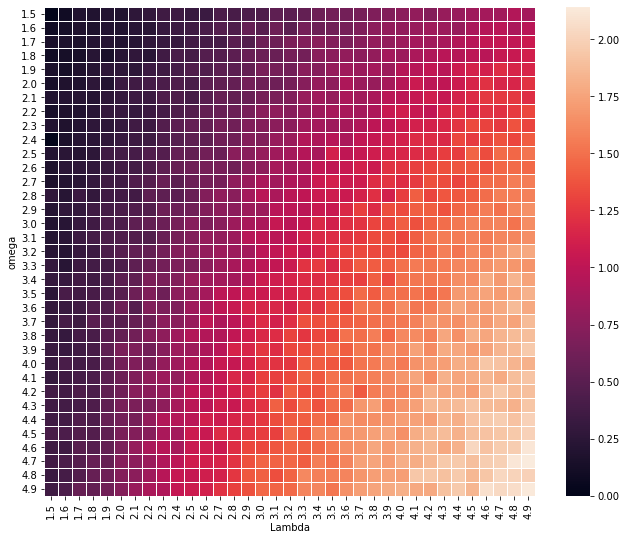

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(MLE, linewidth=0.5, xticklabels=np.around(s_Lambda, decimals=1), 
                 yticklabels=np.around(s_omega, decimals=1))
ax.set_xlabel('Lambda')
ax.set_ylabel('omega')
plt.show()